In [1]:
import numpy as np
import sympy as sp

import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, fixed
from matplotlib.patches import Polygon
from shapely.geometry import LineString
from shapely.geometry import Polygon as Poly

import math

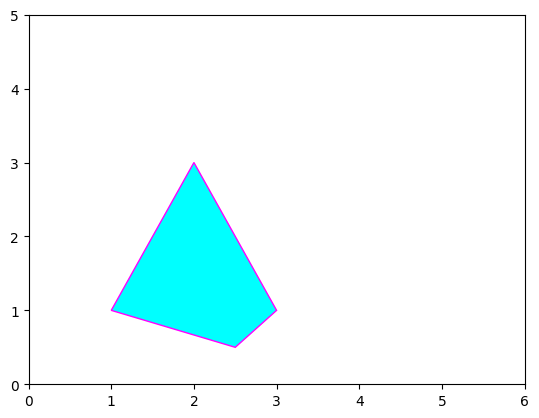

In [2]:
vertices = np.array([(1,1), (2, 3), (3, 1), (2.5, 0.5)])
poly = Polygon(vertices, closed=True, edgecolor='magenta', facecolor='cyan', alpha=1)
ax = plt.subplot()
ax.add_patch(poly)

ax.set_xlim(0, 6)
ax.set_ylim(0, 5)

plt.show()

#### Формула Шонке для вычисления площади простого полигона

Пусть у нас есть простой многоугольник с вершинами $ (x_1, y_1), (x_2, y_2), \ldots, (x_n, y_n) $, которые перечислены в порядке обхода (по часовой стрелке или против часовой стрелки). Площадь этого многоугольника \(A\) вычисляется по формуле:

$$
A = \frac{1}{2} \left| \sum_{i=1}^{n} (x_i y_{i+1} - y_i x_{i+1}) \right|
$$

где $(x_{n+1}, y_{n+1}) = (x_1, y_1)$ (т.е. последняя вершина замыкается первой).

In [3]:
class MyPoly:
    def __init__(self, points):
        self.points_ = np.array(points)

    @property
    def points(self):
        """
        return: 
            точки полигона
        """
        return self.points_

    @property
    def perimeter(self):
        """
        return: 
            периметр полигона
        """
        closed_points = np.vstack([self.points_, self.points_[0]]) # Добавляем первую точку в конец для замыкания полигона
        diffs = np.diff(closed_points, axis=0) # Вычисляем евклидово расстояние между соседними точками
        lengths = np.sqrt(np.sum(np.power(diffs, 2), axis=1)) # Вычисляем длины сторон как длины векторов
        return np.sum(lengths)

    @property
    def area(self):
        """
        return: 
            площадь полигона
        """
        x = self.points_[:, 0]
        y = self.points_[:, 1]
        result = 0.5 * (np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
        return result

    def get_orientation(self):
        """
        return:
            1: против часовой
            -1: по часовой
            None: что-то другое (Точки коллинеарны или совпадают)
        """
        area = self.area
        if area > 0: # 
            return 1
        elif area < 0: # по часовой
            return -1
        else:
            return None

    def is_convex(self):
        """
        Опрпеделяет вогнутость полигона
        
        return:
            True: выпуклый
            False: вогнутый
        """
        n = len(self.points_)
        if n < 3:  # Полигоны с менее чем 3 вершинами не являются выпуклыми
            return False
        direction = None
        for i in range(n):
            p1 = self.points_[i]
            p2 = self.points_[(i + 1) % n]
            side_vector = p2 - p1
            normal_vector = np.array([-side_vector[1], side_vector[0]])
            for j in range(n):
                if j == i or j == (i + 1) % n:
                    continue
                point_vector = self.points_[j] - p1
                dot_product = np.dot(normal_vector, point_vector)
                if direction is None:
                    direction = np.sign(dot_product)
                elif direction != np.sign(dot_product) and dot_product != 0: 
                    return False
        return True

    def is_self_intersecting(self):
        """
        Проверяет самопересечение полигона.
        return: 
            True, если полигон самопересекается
            False, если нет
        """
        n = len(self.points_)
        # Проходим по всем ребрам полигона
        for i in range(n):
            seg1_start = self.points_[i]
            seg1_end = self.points_[(i + 1) % n]  # Зацикливание для последнего сегмента
            seg1 = LineString([seg1_start, seg1_end])
            
            # Проверяем пересечения только с сегментами, которые не смежны
            for j in range(i + 2, n + (i > 0)):  # Пропускаем соседние сегменты
                if (j + 1) % n == i:  # Проверка, чтобы сегменты не были смежными
                    continue
                seg2_start = self.points_[j % n]
                seg2_end = self.points_[(j + 1) % n]
                seg2 = LineString([seg2_start, seg2_end])

                # Проверяем пересечение сегментов
                if seg1.intersects(seg2):
                    return True
        return False

    def intersects_line(self, line_points):
        """
            Проверяет пересечение прямой и полигона.

            Args:
                line_points: numpy.ndarray с координатами двух точек прямой.

            Returns:
                bool: True, если есть пересечение, иначе False.
        """

        line = LineString(np.array(line_points))
        poly = Poly(self.points_)
        return line.intersects(poly)
    
    @property
    def plot(self):
        """
        return: 
            отображение полигона
        """
        poly_ = Polygon(self.points_, closed=True, edgecolor='magenta', facecolor='cyan', alpha=1)
        plt.clf()
        ax = plt.subplot()
        ax.add_patch(poly_)
        x_min, y_min = np.min(self.points_[:,0]),np.min(self.points_[:,1])
        x_max, y_max = np.max(self.points_[:,0]),np.max(self.points_[:,1])
        ax.set_xlim(xmin=x_min-1, xmax=x_max+1)
        ax.set_ylim(ymin=y_min-1, ymax=y_max+1)
        return ax
    
    def __repr__(self):
        """
        return: 
            строковое представление
        """
        return f'Polygon wits points {tuple(self.points_)}'

In [4]:
a = MyPoly([(1,1), (2, 3), (3, 1), (2.5, 0.5)])

In [5]:
a

Polygon wits points (array([1., 1.]), array([2., 3.]), array([3., 1.]), array([2.5, 0.5]))

<Axes: >

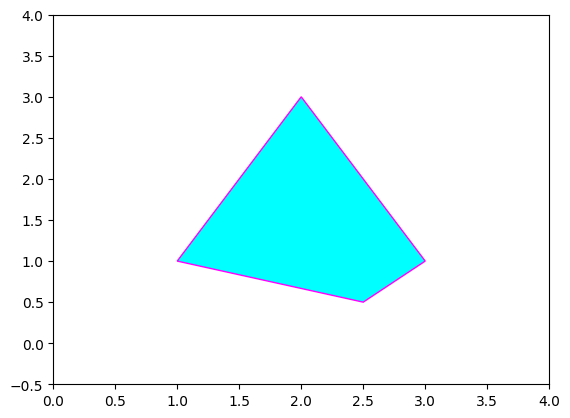

In [6]:
a.plot

# 1

### 1.1

Напишите функцию, вычисляющую периметр произвольного полигона.

In [7]:
a.perimeter

6.7603815662703175

In [8]:
?a.perimeter

Type:        property
String form: <property object at 0x0000022DCD944C20>
Docstring:  
return: 
    периметр полигона

### 1.2

Напишите функцию, вычисляющую площадь произвольного простого
полигона.

In [9]:
a.area

2.5

In [10]:
?a.area

Type:        property
String form: <property object at 0x0000022DCD944E00>
Docstring:  
return: 
    площадь полигона

### 1.3

Создайте тест-функцию для определения направления обхода произвольного
простого полигона. 

In [11]:
a.get_orientation()

1

In [12]:
?a.get_orientation

Signature: a.get_orientation()
Docstring:
return:
    1: против часовой
    -1: по часовой
    None: что-то другое (Точки коллинеарны или совпадают)
File:      c:\temp\ipykernel_16832\1436302404.py
Type:      method

### 1.4

Напишите тест-функцию выпуклости произвольного простого полигона.

In [13]:
a.is_convex()

True

In [14]:
?a.is_convex

Signature: a.is_convex()
Docstring:
Опрпеделяет вогнутость полигона

return:
    True: выпуклый
    False: вогнутый
File:      c:\temp\ipykernel_16832\1436302404.py
Type:      method

### 1.5

Напишите тест-функцию самопересечения полигона. 

In [15]:
# Пример полигона, который пересекается сам с собой
poly_points = [(0, 0), (2, 2), (0, 4), (4, 0), (2, 4)]
polygon = MyPoly(poly_points)

# Пример выпуклого полигона, который не пересекается сам с собой
convex_poly_points = [(0, 0), (0, 4), (4, 4), (4, 0)]
convex_polygon = MyPoly(convex_poly_points)
polygon.is_self_intersecting(), convex_polygon.is_self_intersecting() 

(True, False)

In [16]:
a.is_self_intersecting()

False

### 1.7

Напишите функцию, вычисляющую взаимное положение полигона и прямой
линии. 

In [17]:
def get_coefs(line):
    a = line[0]
    b = line[1]
    v = b-a
    return v[1], -v[0], -(v[1] * a[0] + (-v[0]) * a[1])

In [46]:
def between_line_and_segment(line, ab):
    """
    Определяет взаимное расположение прямой L и отрезка ab.
    """
    a_line, b_line, _ = get_coefs(line)
    a_seg, b_seg, _ = get_coefs(ab)
    x1, y1 = line[0] 
    x2, y2 = line[1]
    x3, y3 = ab[0]
    x4, y4 = ab[1]
    
    osn = (x1-x2)*(y3-y4) - (y1-y2)*(x3-x4)

    if np.isclose(osn, 0):
        if a_line == a_seg and b_line == b_seg:
            return ab, "отрезок" # отрезок на прямой
        else:
            "None" # отрезок не пересекается
    
    Px = ((x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4)) / osn
    Py = ((x1*y2-y1*x2)*(y3-y4)-(y1-y2)*(x3*y4-y3*x4)) / osn

    # print(Px, Py)
    
    if min(x3, x4) <= Px <= max(x3, x4) and min(y3, y4) <= Py <= max(y3, y4):
        return np.array([Px, Py])
    else:
        return "None"
    
    


In [43]:
def line_and_poly(line, poly):
    points = poly.points
    points_result = []
    segments_result = []

    # Проверяем, находятся ли обе точки отрезка внутри полигона
    p1_inside = point_in_poly_bool(line[0], poly)
    p2_inside = point_in_poly_bool(line[1], poly)

    if p1_inside and p2_inside:
        return "Не пересекает"  # Отрезок полностью внутри полигона

    for i in range(len(points)):
        point1 = points[i]
        point2 = points[(i + 1) % len(points)]
        temp_res = between_line_and_segment(line, np.array([point1, point2]))

        if isinstance(temp_res, str):
            continue  # Нет пересечения
        elif isinstance(temp_res, tuple):
            # Пересечение с отрезком полигона
            segments_result.append(temp_res[0])
        else:
            # Пересечение в точке
            points_result.append(temp_res)

    # Убираем дубликаты точек пересечения
    points_result = np.unique(points_result, axis=0)

    # Если есть пересечения с отрезками
    if segments_result:
        return "Пересекает отрезки", np.array(segments_result)

    # Если есть пересечения в точках
    if points_result.size > 0:
        return "Пересекает точки", points_result

    # Если пересечений нет
    return "Не пересекает"

In [44]:
result = line_and_poly(np.array([[1, 0.5], [5, 5]]), a)

In [45]:
result

('Пересекает точки',
 array([[1.34285714, 0.88571429],
        [2.44      , 2.12      ]]))

### 1.6

Напишите булеву функцию, определяющую пересечение
прямой и полигона.

In [24]:
def line_and_poly_bool(line, poly):
    points = poly.points
    points_result = []
    segments_result = []
    for i in range(len(points)):
        point1 = points[i]
        point2 = points[(i+1) % len(points)]
        temp_res = between_line_and_segment(line, np.array([point1, point2]))
        if isinstance(temp_res, str):
            continue
        elif isinstance(temp_res, tuple):
            return True
        else:
            return True
    return False

In [25]:
line_and_poly_bool(np.array([[5, 4],[10, 4]]), a)

False

# 2

### 2.1

Напишите функцию, определяющую гарантированную непринадлежность
заданной точки полигону. 

In [26]:
def kdistance(line, point):
    A, B, C = get_coefs(line)
    x0, y0 = point
    distance = (A * x0 + B * y0 + C) / np.sqrt(A**2 + B**2)
    return distance

def point_in_poly_bool(point, poly:Poly):
    """
    Если точка внутри или на границе полигона True, иначе False
    """
    points = poly.points
    for i in range(len(points)):
        point1 = points[i]
        point2 = points[(i+1) % len(points)]
        temp_res = kdistance(np.array([point1, point2]), point)
        if temp_res < 0:
            return False
    return True

In [27]:
point_in_poly_bool([-1, 1],a)

False

### 2.2 

Напишите тест-функцию определения положения точки относительно
выпуклого полигона.

In [28]:
def point_in_poly(point, poly:Poly):
    points = poly.points
    for i in range(len(points)):
        point1 = points[i]
        point2 = points[(i+1) % len(points)]
        temp_res = kdistance(np.array([point1, point2]), point)
        if temp_res == 0:
            return f"Точка лежит на границе(отрезке) {[tuple(point1), tuple(point2)]}"
        elif temp_res < 0:
            return "Точка вне полигона"
    return "Точка внутри полигона"

In [29]:
point_in_poly([1, 0],a)

'Точка вне полигона'

### 2.3

Напишите функцию, реализующую угловой тест, определяющий положение
точки относительно произвольного простого полигона. 

In [30]:
def get_angle(p1, p2):
    return np.arctan2(p2[1] - p1[1], p2[0] - p1[0])

In [31]:
def point_in_poly_angle(poly, point):
    """
    Вычисляем разность углов между точкой и соседними вершинами полигона и аккумулируем их, чтобы получить суммарный угол. 
    Если суммарный угол близок к 2π или −2π, точка находится внутри полигона.
    """
    points = poly.points
    angles = []
    for i in range(len(points)):
        angle = get_angle(point, points[i]) - get_angle(point, points[(i + 1) % len(points)])
        angles.append(np.arctan2(np.sin(angle), np.cos(angle)))
    return abs(sum(angles)) > 1e-10

In [32]:
point_in_poly_angle(a, [1, 1])

False

### 2.4

Напишите функцию, реализующую лучевой тест, определяющий положение
точки относительно произвольного простого полигона. 

In [33]:
def point_on_edge(p1, p2, point):
    px, py = point
    p1x, p1y = p1
    p2x, p2y = p2
    if p1x != p2x:
        if not (min(p1x, p2x) <= px <= max(p1x, p2x)):
            return False
    if p1y != p2y:
        if not (min(p1y, p2y) <= py <= max(p1y, p2y)):
            return False
    return (px - p1x) * (p2y - p1y) == (py - p1y) * (p2x - p1x)

def point_in_poly_ray(poly:Poly, point):
    points = poly.points
    x, y = point
    n = len(points)
    inside = False

    p1x, p1y = points[0]
    for i in range(1, n + 1):
        p2x, p2y = points[i % n]
        if point_on_edge((p1x, p1y), (p2x, p2y), point):
            # print(inside)
            return True
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
        # print(inside)

    return inside

In [34]:
point_in_poly_ray(a, [0, -1])

False

# 3

### 3.1

Напишите функцию, реализующую операцию отсечения отрезка выпуклым
полигоном (или внутреннее, или внешнее, в зависимости от значения
аргумента).


Используйте метод анализа значений параметров, соответствующих точкам
пересечения ребер полигона и параметризованной прямой, несущей отрезок. 


In [35]:
def clip_line_with_polygon(line_points, polygon, clip_type="inner"):
    """
    Отсекает отрезок выпуклым полигоном.

    Args:
        line_points (np.ndarray): Координаты двух точек отрезка.
        polygon (MyPoly): Выпуклый полигон.
        clip_type (str): Тип отсечения. "inner" для внутреннего отсечения, "outer" для внешнего.

    Returns:
        list: Список отрезков, полученных после отсечения.
    """
    if not polygon.is_convex():
        raise ValueError("Полигон должен быть выпуклым.")

    # Получаем результат пересечения отрезка с полигоном
    intersection_result = line_and_poly(line_points, polygon)

    # Если пересечений нет
    if intersection_result == "Не пересекает":
        # Проверяем, лежат ли обе точки отрезка внутри полигона
        p1_inside = point_in_poly_bool(line_points[0], polygon)
        p2_inside = point_in_poly_bool(line_points[1], polygon)

        if p1_inside and p2_inside:
            if clip_type == "inner":
                return [line_points]  # Отрезок полностью внутри
            else:
                return []  # Отрезок полностью внутри, но для outer возвращаем пустой список
        else:
            if clip_type == "inner":
                return []  # Отрезок полностью снаружи
            else:
                return [line_points]  # Отрезок полностью снаружи, но для outer возвращаем его

    # Если есть пересечения
    if intersection_result[0] == "Пересекает точки":
        intersections = intersection_result[1]
    elif intersection_result[0] == "Пересекает отрезки":
        intersections = intersection_result[1].reshape(-1, 2)  # Преобразуем отрезки в точки
    else:
        raise ValueError("Неожиданный результат пересечения.")

    # Если пересечение одно
    if len(intersections) == 1:
        p1_inside = point_in_poly_bool(line_points[0], polygon)
        p2_inside = point_in_poly_bool(line_points[1], polygon)

        if p1_inside:
            if clip_type == "inner":
                return [np.array([line_points[0], intersections[0]])]
            else:
                return [np.array([intersections[0], line_points[1]])]
        elif p2_inside:
            if clip_type == "inner":
                return [np.array([line_points[1], intersections[0]])]
            else:
                return [np.array([line_points[0], intersections[0]])]
        else:
            return []

    # Если пересечений два
    if len(intersections) == 2:
        # Проверяем, лежит ли середина отрезка между пересечениями внутри полигона
        mid_point = (intersections[0] + intersections[1]) / 2
        mid_inside = point_in_poly_bool(mid_point, polygon)

        if mid_inside:
            if clip_type == "inner":
                return [intersections]  # Возвращаем отрезок между пересечениями
            else:
                # Возвращаем два отрезка: до первого пересечения и после второго
                return [
                    np.array([line_points[0], intersections[0]]),
                    np.array([intersections[1], line_points[1]])
                ]
        else:
            if clip_type == "inner":
                return []  # Отрезок полностью снаружи
            else:
                # Возвращаем два отрезка: между пересечениями
                return [intersections]

    # Если пересечений больше двух, это ошибка (выпуклый полигон не может иметь больше двух пересечений)
    raise ValueError("Полигон не является выпуклым или произошла ошибка.")

In [36]:
clip_line_with_polygon(np.array([[2,1.5], [2, 2]]), a)

[array([[2. , 1.5],
        [2. , 2. ]])]

# 4

## 4.1

Напишите функцию, реализующую отсечение произвольного простого
полигона произвольным простым полигоном, область видимости –
внутренность отсекателя.

In [47]:
def is_convex_polygon(polygon): # не используется
    """
    Проверяет, является ли полигон выпуклым.

    Args:
        polygon (list): Список точек полигона.

    Returns:
        bool: True, если полигон выпуклый, иначе False.
    """
    n = len(polygon)
    if n < 3:
        return False

    direction = None
    for i in range(n):
        p1 = polygon[i]
        p2 = polygon[(i + 1) % n]
        p3 = polygon[(i + 2) % n]

        cross_product = np.cross(p2 - p1, p3 - p2)

        if direction is None:
            direction = np.sign(cross_product)
        elif direction != np.sign(cross_product):
            return False

    return True

def point_in_polygon(point, polygon): # не используется
    """
    Проверяет, находится ли точка внутри полигона.

    Args:
        point (np.ndarray): Координаты точки.
        polygon (list): Список точек полигона.

    Returns:
        bool: True, если точка внутри полигона или на его границе, иначе False.
    """
    n = len(polygon)
    winding_number = 0

    for i in range(n):
        p1 = polygon[i]
        p2 = polygon[(i + 1) % n]

        if p1[1] <= point[1]:
            if p2[1] > point[1] and np.cross(p2 - p1, point - p1) > 0:
                winding_number += 1
        else:
            if p2[1] <= point[1] and np.cross(p2 - p1, point - p1) < 0:
                winding_number -= 1

    return winding_number != 0

def line_segment_intersection(line, segment):
    """
    Проверяет пересечение отрезка с линией.

    Args:
        line (np.ndarray): Две точки, определяющие линию.
        segment (np.ndarray): Две точки, определяющие отрезок.

    Returns:
        np.ndarray or None: Координаты точки пересечения или None, если пересечения нет.
    """
    x1, y1, x2, y2 = *line[0], *line[1]
    x3, y3, x4, y4 = *segment[0], *segment[1]

    denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if np.isclose(denominator, 0):
        return None

    Px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denominator
    Py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denominator

    if min(x3, x4) <= Px <= max(x3, x4) and min(y3, y4) <= Py <= max(y3, y4):
        return np.array([Px, Py])

    return None

def clip_polygon(subject_polygon, clipper_polygon):
    """
    Отсекает произвольный простой полигон другим простым полигоном.

    Args:
        subject_polygon (list): Список точек исходного полигона.
        clipper_polygon (list): Список точек полигона-отсекателя.

    Returns:
        list: Координаты отсеченного полигона.
    """
    def inside(point, edge_start, edge_end):
        return np.cross(edge_end - edge_start, point - edge_start) >= 0

    def compute_intersection(p1, p2, edge_start, edge_end):
        line = np.array([edge_start, edge_end])
        segment = np.array([p1, p2])
        return line_segment_intersection(line, segment)

    output_list = subject_polygon

    for i in range(len(clipper_polygon)):
        input_list = output_list
        output_list = []

        edge_start = clipper_polygon[i - 1]
        edge_end = clipper_polygon[i]

        for j in range(len(input_list)):
            current_point = input_list[j]
            prev_point = input_list[j - 1]

            if inside(current_point, edge_start, edge_end):
                if not inside(prev_point, edge_start, edge_end):
                    intersection = compute_intersection(prev_point, current_point, edge_start, edge_end)
                    if intersection is not None:
                        output_list.append(intersection)
                output_list.append(current_point)
            elif inside(prev_point, edge_start, edge_end):
                intersection = compute_intersection(prev_point, current_point, edge_start, edge_end)
                if intersection is not None:
                    output_list.append(intersection)

    return np.array(output_list).tolist()

# Пример использования
subject_polygon = np.array([[1, 1], [5, 1], [5, 5], [1, 5]])
clipper_polygon = np.array([[3, 3], [7, 3], [7, 7], [3, 7]])

result = clip_polygon(subject_polygon, clipper_polygon)
print("Результат отсечения:", result)


Результат отсечения: [[3.0, 3.0], [5.0, 3.0], [5.0, 5.0], [3.0, 5.0]]


In [48]:
s = MyPoly(subject_polygon)
c = MyPoly(clipper_polygon)

<Axes: >

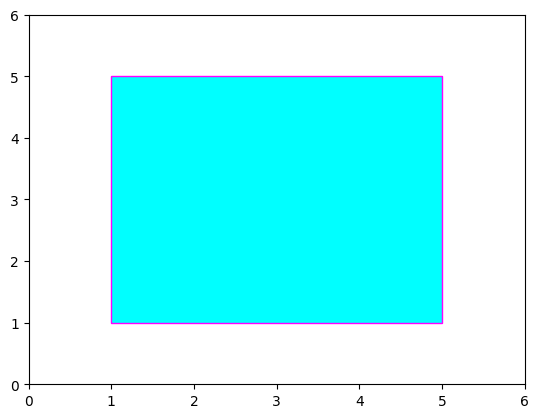

In [49]:
s.plot

<Axes: >

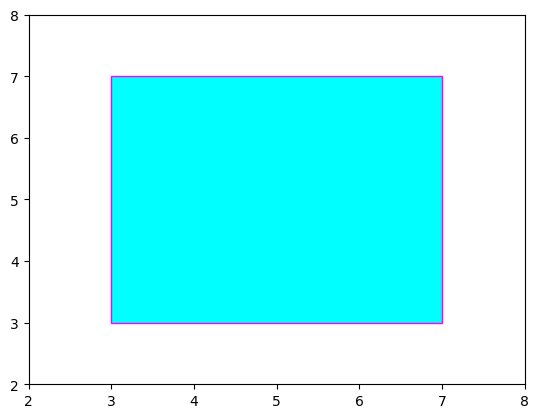

In [50]:
c.plot

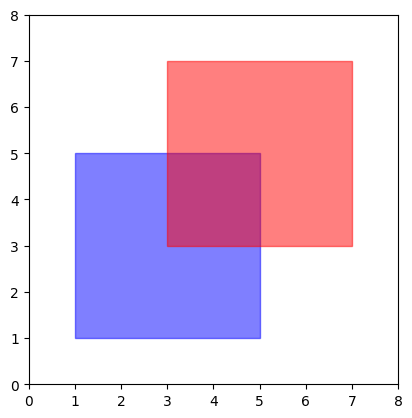

In [54]:
fig, ax = plt.subplots()

# Добавляем первый полигон
subject = Polygon(subject_polygon, closed=True, color='blue', alpha=0.5)
ax.add_patch(subject)

# Добавляем второй полигон
clipper = Polygon(clipper_polygon, closed=True, color='red', alpha=0.5)
ax.add_patch(clipper)

# Настраиваем оси
ax.set_xlim(0, 8)
ax.set_ylim(0, 8)
ax.set_aspect('equal', adjustable='box')

plt.show()